<p>
Os dados da boia estão referenciados com base no norte magnético, ou seja 21°W em relação ao norte geográfico. As linhas de batimetria do ponto de fundeio possuem uma inclinacão de 60°W em relação ao norte geográfico. Para o cálculo das componentes paralelas e perpendiculares à costa os dados aqui tratados serão rotacionados 39W.
</p>

In [1]:
import filters
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
def calcula_uv(magnitude, direcao):
    """
    Funcao para calcular componentes u e v de
    correntes na orientacao oceanografica. Ref:
    Long, David G. Display and computation of
    winds in oceanography and Meteorology.
    MERS Technical Report.
    
    """
    from numpy import deg2rad, cos, sin
    phi_u = (90 - direcao) % 360
    phi_u = deg2rad(phi_u) #radianos
    u = magnitude * cos(phi_u) #zonal
    v = magnitude * sin(phi_u) #meridional
    return u, v

In [3]:
path = '/home/gus/Documentos/mestrado/dados-mestrado/dados-adcp-completos'

In [4]:
df = pd.read_csv(path+'/adcp_fortaleza.csv', delimiter=';')

In [5]:
df.shape

(9129, 44)

<p style="font-size:20px; color:black"> Velocidade </p>

In [6]:
velocity = np.array(df.iloc[:,4:45:2])*0.1
direction = np.array(df.iloc[:,5:45:2])


In [7]:
#Velocity = df.iloc[:,4:45:2]*0.1;
#Direction = df.iloc[:,5:45:2]

##### rotacionando  os dados

In [8]:
# correcao magnetica e rotacao 
#direction += 21
#direction[direction >360] -= 360


##### calculo de u e v

In [9]:
componentes = calcula_uv(velocity, direction)
u, v = componentes[0], componentes[1]
del componentes

In [10]:
u.shape, v.shape

((9129, 20), (9129, 20))

<p style="font-size:20px; color:black"> Tempo </p>

In [11]:
Ano = (df.year+2000).astype(str);
Mes = df.month.astype(str);
Dia = df.day.astype(str);
Hora = df.hour.astype(str);

Time = Dia+'/'+ Mes + '/'+ Ano +' '+ Hora +':'+'00';

del Ano, Mes, Dia, Hora;

In [12]:
timeBoia = [];

for iterator in Time:
    timeBoia.append(dt.datetime.strptime
                     (iterator,'%d/%m/%Y %H:%M'));
del Time;

In [13]:
timeContinuo = pd.date_range(start='2016-11-18 20:00',
                             end ='2017-12-04 13', freq='1H')
print(timeContinuo.shape)

(9138,)


<p style="font-size:16px; color:black"> Criando uma matriz sem lacunas no tempo para receber os dados
de u e v </p>

In [14]:
if len(timeBoia) != len(timeContinuo):
    print('Os dados da boia possuem lacunas no tempo')

Os dados da boia possuem lacunas no tempo


In [15]:
del df

In [16]:
u_tempo_continuo = np.zeros([len(timeContinuo), 20])
v_tempo_continuo = np.zeros([len(timeContinuo), 20])

u_tempo_continuo.fill(np.nan)
v_tempo_continuo.fill(np.nan)

<p style="font-size:16px; color:black"> Preenchendo as matrizes <b>u </b> e <b>v</b> continuas no tempo </p>

In [17]:
%time

line = 0

for time in timeBoia:

    idx = np.where(timeContinuo == time)

    idx = idx[0]

    u_tempo_continuo[idx,:] = u[line,:]

    v_tempo_continuo[idx,:] = v[line,:]

    line += 1

u = np.copy(u_tempo_continuo)

v = np.copy(v_tempo_continuo)

#del (u_tempo_continuo, v_tempo_continuo, direction,
#    timeBoia, velocity, time)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.9 µs


<p style="font-size:20px; color:black"> Filtros de limpeza </p> 
<p>Aqui irei passar o filtro de media temporal sobre os dados u e v </p>

In [18]:
uFiltrado= np.copy(u)
vFiltrado = np.copy(v)

uFiltrado.fill(np.NaN)
vFiltrado.fill(np.NaN)
   

In [19]:
%%time

for colunm in range(0,20,1):
    
    x = filters.remove_outliers( u[:, colunm], 6)
    y = filters.remove_outliers( v[:, colunm], 6)
    
    uFiltrado [:, colunm] = x
    vFiltrado [:, colunm] = y
    
    del x, y

/home/gus/Documentos/scripts/python_scripts/corrente/adcp/filters.py:28: RuntimeWarning: Mean of empty slice
  mean = nanmean(vector[line - window:
/home/gus/miniconda3/envs/ocean_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CPU times: user 1min 24s, sys: 168 ms, total: 1min 24s
Wall time: 1min 24s


In [20]:
# substituindo -99999 por NaN

uFiltrado[uFiltrado == -99999] = np.NaN
vFiltrado[vFiltrado== -99999] = np.NaN

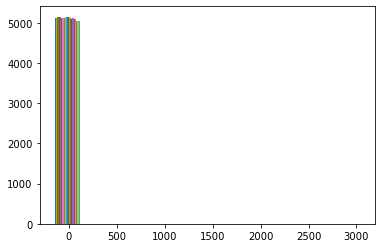

In [21]:
plt.hist(vFiltrado);

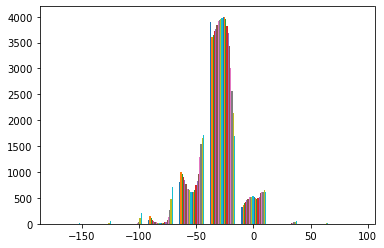

In [22]:
plt.hist(uFiltrado);

In [23]:
#v_filtered[v_filtered > 250] = np.NaN
#u_filtered[u_filtered > 250] = np.NaN

In [26]:
# contando a ocorrencia de valores > 150 cm/s
for column in range(20):
    print((uFiltrado[:,column]>150).sum(),\
          '\t',(vFiltrado[:,column]>150).sum())

0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 6
0 	 4
0 	 5
0 	 4
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 1


In [27]:
#contando a ocorrencia de valores < -150cm/s
for column in range(20):
    print((uFiltrado[:,column]<-150).sum(),\
          '\t',(vFiltrado[:,column]<-150).sum())

0 	 0
0 	 0
0 	 0
0 	 0
0 	 1
0 	 1
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
0 	 0
7 	 1


<p style="font-size:20px; color:black">Salvando os dados rotacionados e limpos </p>

In [28]:
uFiltrado = pd.DataFrame(uFiltrado)
vFiltrado = pd.DataFrame(vFiltrado)

In [29]:
numeros = np.arange(1, 21, 1)
u_names = ['u'+str(ii) for ii in numeros]
v_names = ['v'+str(ii) for ii in numeros]

In [30]:
# nome das colunas
uFiltrado.columns = u_names
vFiltrado.columns = v_names

In [31]:
uFiltrado.describe()

,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,u16,u17,u18,u19,u20
count,5095.000000,5121.000000,5125.000000,5136.000000,5128.000000,5135.000000,5137.000000,5142.000000,5134.000000,5132.000000,5114.000000,5115.000000,5100.000000,5099.000000,5086.000000,5083.000000,5079.000000,5070.000000,5089.000000,5072.000000
mean,-29.682421,-31.600401,-30.636503,-29.801318,-29.084540,-28.336859,-27.506386,-27.464396,-27.134142,-26.855432,-26.825103,-27.004955,-27.387555,-27.899873,-28.448843,-29.424954,-32.037823,-35.011584,-38.736942,-44.329472
std,12.937629,14.990110,14.380169,13.787517,13.212628,12.791102,12.294058,12.095897,11.812572,11.535763,11.466917,11.494633,11.814076,12.510155,13.555590,15.276901,17.649218,20.598713,24.880695,29.759710
min,-82.764632,-96.634897,-97.353669,-93.595635,-88.647479,-88.716816,-87.772978,-84.946067,-83.898602,-80.932222,-81.301095,-79.459656,-82.815992,-93.254582,-96.866433,-108.236300,-114.966731,-128.822039,-149.475474,-176.069663
25%,-36.373936,-39.133140,-38.345142,-37.342647,-36.686760,-35.825208,-34.666165,-34.725450,-34.153346,-34.100434,-33.861048,-34.030630,-34.375417,-35.099487,-35.960535,-38.107009,-42.420437,-47.327586,-53.137633,-61.890721
50%,-27.807413,-29.387222,-28.712131,-27.933085,-27.571885,-27.081676,-26.504785,-26.473354,-26.114613,-25.931877,-25.962533,-25.875791,-26.112070,-26.529736,-27.410032,-28.660625,-30.921256,-33.670572,-37.201061,-42.539764
75%,-21.061510,-21.479495,-20.826319,-20.537739,-20.033973,-19.687038,-19.247116,-19.170723,-19.028295,-18.891355,-18.997902,-19.157661,-19.454679,-19.695171,-19.774590,-19.639601,-20.650272,-21.697353,-22.340874,-24.519901
max,49.081359,58.799921,50.667243,62.158035,62.535207,95.208833,48.118030,52.648375,72.037258,48.695552,73.719143,56.644237,72.605249,38.795846,48.000000,55.522199,64.756780,69.804252,70.651787,91.327104


In [32]:
vFiltrado.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20
count,5112.000000,5131.000000,5139.000000,5155.000000,5146.000000,5135.000000,5130.000000,5132.000000,5150.000000,5147.000000,5147.000000,5136.000000,5127.000000,5109.000000,5117.000000,5108.000000,5087.000000,5055.000000,5047.000000,5055.000000
mean,22.984222,26.512572,26.667480,26.275253,26.002296,25.579946,27.683634,26.658537,26.357051,25.404934,23.783167,22.833982,21.467188,19.073005,16.218535,12.527994,9.268105,4.722912,0.018138,2.989352
std,13.035914,14.087672,13.807562,13.605980,13.378443,12.934003,82.139228,53.627463,45.614013,35.179330,12.990751,12.820557,12.894347,13.272466,13.967095,15.125452,17.037667,19.980606,23.759484,31.650320
min,-15.290421,-38.341184,-19.808075,-116.902261,-162.909784,-179.061772,-25.336412,-107.945165,-95.596671,-50.425720,-47.873771,-30.918084,-65.374060,-79.543273,-83.138439,-79.293918,-92.482266,-99.690804,-144.885600,-153.392847
25%,14.833901,17.268237,17.457537,17.122586,17.009202,16.896560,16.600903,16.449945,16.236156,15.789692,15.204282,14.283305,12.853180,10.379196,7.194135,2.826284,-1.521159,-7.140816,-13.213321,-15.428151
50%,21.577515,24.864637,24.954031,24.749591,24.549536,24.233093,23.700628,23.850033,23.639611,23.110777,22.433288,21.650318,20.490981,18.397447,15.947374,12.530727,9.474033,5.466311,0.701587,1.912084
75%,29.127847,33.442828,33.440171,33.349358,33.170536,32.715337,32.093181,32.582240,32.352576,31.622210,31.124236,30.178715,29.105779,27.352628,25.016176,22.646897,20.511677,17.692188,15.256225,20.863201
max,128.527549,108.272678,95.744630,88.960245,87.641771,82.214252,3062.300000,1961.401224,1552.400000,1234.311980,86.545580,86.705805,85.015493,84.711695,84.283011,87.546636,84.027287,80.004637,83.620905,157.616329


In [33]:
#add o tempo
uFiltrado['time'] =  timeContinuo;
vFiltrado['time'] =  timeContinuo;

#salvando o dado
uFiltrado.to_csv(path+'/adcp-zonal-limpo.csv', sep=';',index = False)
vFiltrado.to_csv(path+'/adcp-meridional-limpo.csv', sep=';',index = False)

(-50.0, 100.0)

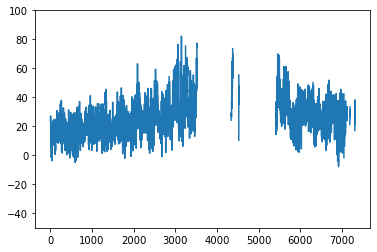

In [34]:
plt.plot(vFiltrado.iloc[:,5])
plt.ylim([-50, 100])

<AxesSubplot:>

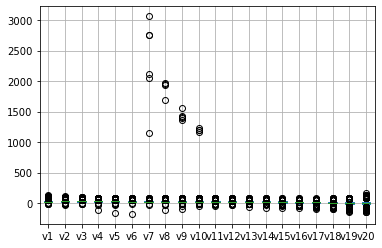

In [35]:
vFiltrado.boxplot()

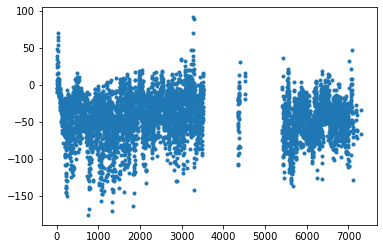

In [36]:
plt.plot(uFiltrado.iloc[:,19],'.')
#plt.ylim([-100, 50])